__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пт 14 июн 2024 14:31:48 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

17795

title  \
10742        участок 10 сот. (ижс)   
6842          участок 9 сот. (ижс)   
17181  участок 7,7 сот. (снт, днп)   

                                                  address   latitude  \
10742                             севастополь,с.оборонное  44.517208   
6842                              бахчисарай,с.маловидное  44.796945   
17181  севастополь,садоводческое товарищество движенец,51   44.57975   

       longitude  priceM          dt  
10742   33.65257    3.60  2024-06-14  
6842   33.809973    1.40  2024-06-14  
17181  33.545563    3.60  2024-06-07

---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

title                                        address  \
10069  Участок 12 сот. (ИЖС)       Севастополь,с. Широкое, ул. Клюшкина, 61   
2627   Участок 15 сот. (ИЖС)       Севастополь,с. Тыловое, Стахановская ул.   
15474   Участок 4 сот. (ИЖС)  Севастополь,садоводческое товарищество Икар-2   

        latitude  longitude  priceM          dt  
10069   44.48258  33.783123    3.00  2022-10-14  
2627   44.441174   33.73261    1.90  2022-09-13  
15474  44.555771   33.47916    1.70  2022-11-28

In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

title  \
18149  Участок 8,8 сот. (ИЖС)   
14484   Участок 10 сот. (ИЖС)   
4835     Участок 4 сот. (ИЖС)   

                                                      address   latitude  \
18149  Севастополь,садоводческое товарищество Коммутатор, 106  44.516636   
14484                      Севастополь,ул. Николая Шилова, 68  44.564243   
4835                             Севастополь,Песенный пер., 2  44.644418   

       longitude  priceM          dt                          url  
18149  33.514374    2.20  2024-06-05  https://avito.ru/3739512811  
14484  33.594934    4.00  2022-11-15  https://avito.ru/2471625623  
4835   33.586643    3.75  2022-09-16  https://avito.ru/2337967263

In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

36522

In [9]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

In [10]:
display( len(df) )
df = df.query('priceM>1e-3').reset_index(drop=True)
display( len(df) )

36522

36461

In [11]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))
df['log_priceMU'] = df['priceMU'].apply(lambda x: np.log(x+1.))

In [12]:
# df[['area','priceM','priceMU']]

---

In [13]:
# df['dt'].drop_duplicates().sort_values()

In [14]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [15]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [16]:
# df.info()

In [17]:
#           46.319437, 33.911048
#
# 45.402617, 32.455625 |  45.545301, 36.684702
#
#          44.320887, 33.917013

display( len(df) )
df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 
display( len(df) )

36461

36433

In [18]:
df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

In [19]:
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None
df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [20]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

36433

36433

In [21]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [22]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
18259        Участок 10 сот. (ИЖС)   
16774  участок 5,5 сот. (снт, днп)   
24457         Участок 6 сот. (ИЖС)   

                                                        address  latitude  \
18259                            Севастополь,Лукулльская ул., 9     44.83   
16774  севастополь,садоводческое товарищество горнодолинный,180     44.52   
24457                       Севастополь,Фиолентовское ш., 114к1     44.51   

       longitude  priceM          dt                              url  
18259      33.56    1.69  2022-09-08      https://avito.ru/2351940911  
16774      33.54    1.75  2024-06-07  https://www.avito.ru/3860826383  
24457      33.48    5.10  2022-09-22      https://avito.ru/2574496328

In [23]:
display( len(df) )
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")').reset_index(drop=True)
display( len(df) )

36433

36433

---

In [24]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 14)

In [25]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [26]:
# display( len(gdf_history) )
display( len(gdf) )

36420

In [27]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [28]:
# gdf['place'].unique()

# общая статистика

In [29]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [30]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [31]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [32]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [33]:
# (
# gdf.loc[ gdf['address'].str.lower().str.match(r'.*с.лучистое.*') ]
# [['title','place','address','priceM','area_size_category','geometry']]
# .explore() 
# )

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

In [35]:
gdf.loc[ gdf['priceMU']==np.inf, 'priceMU'] = None
gdf['priceMU'] = gdf['priceMU'].fillna( gdf['priceMU'].max()+1. )

In [36]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
    gdf
    .groupby(['place','week'],observed=True)
    # .groupby(['place','month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)

display( stat )

count  mean  std  min   1%   5%  10%  \
place       week                                                            
bahchisaray 2024-06-03/2024-06-09   627.00  0.15 0.27 0.00 0.00 0.00 0.00   
            2024-06-10/2024-06-16  2220.00  0.15 0.28 0.00 0.00 0.00 0.00   
sevastopol  2022-09-05/2022-09-11  1066.00  0.72 0.69 0.00 0.09 0.19 0.25   
            2022-09-12/2022-09-18  4425.00  0.72 0.72 0.00 0.07 0.19 0.25   
            2022-09-19/2022-09-25  2206.00  0.71 0.71 0.00 0.06 0.19 0.25   
            2022-09-26/2022-10-02  1083.00  0.71 0.70 0.00 0.08 0.19 0.25   
            2022-10-03/2022-10-09  1105.00  0.69 0.53 0.00 0.08 0.19 0.25   
            2022-10-10/2022-10-16  1097.00  0.69 0.69 0.00 0.09 0.18 0.24   
            2022-10-31/2022-11-06  2025.00  0.71 1.02 0.00 0.07 0.17 0.23   
            2022-11-07/2022-11-13  1025.00  0.69 0.84 0.00 0.08 0.19 0.23   
            2022-11-14/2022-11-20  1077.00  0.72 1.15 0.00 0.08 0.18 0.24   
            2022-11-28/2022-12-04  1026.00  0.66 0.68 0.00 0.09 0.19 0.24   
            2023-01-09/2023-01-15   824.00  0.66 0.55 0.00 0.08 0.17 0.24   
            2024-06-03/2024-06-09  4391.00  0.76 1.08 0.00 0.02 0.10 0.20   
            2024-06-10/2024-06-16 10537.00  0.75 1.21 0.00 0.01 0.06 0.15   
sudak       2024-06-03/2024-06-09   330.00  0.62 0.70 0.00 0.02 0.07 0.13   
            2024-06-10/2024-06-16  1356.00  0.61 0.65 0.00 0.01 0.07 0.13   

                                   25%  50%  75%  90%  95%   max  
place       week                                                  
bahchisaray 2024-06-03/2024-06-09 0.01 0.05 0.20 0.39 0.56  4.67  
            2024-06-10/2024-06-16 0.01 0.05 0.20 0.37 0.56  4.67  
sevastopol  2022-09-05/2022-09-11 0.38 0.55 0.88 1.29 1.77 15.00  
            2022-09-12/2022-09-18 0.39 0.55 0.88 1.29 1.72 15.00  
            2022-09-19/2022-09-25 0.38 0.55 0.88 1.28 1.71 15.00  
            2022-09-26/2022-10-02 0.38 0.55 0.88 1.28 1.66 15.00  
            2022-10-03/2022-10-09 0.36 0.54 0.87 1.20 1.56  5.26  
            2022-10-10/2022-10-16 0.36 0.55 0.86 1.16 1.58 15.00  
            2022-10-31/2022-11-06 0.37 0.52 0.83 1.15 1.58 16.00  
            2022-11-07/2022-11-13 0.38 0.52 0.83 1.14 1.61 16.00  
            2022-11-14/2022-11-20 0.36 0.50 0.81 1.20 1.65 16.00  
            2022-11-28/2022-12-04 0.35 0.50 0.81 1.14 1.57 15.00  
            2023-01-09/2023-01-15 0.36 0.52 0.83 1.14 1.56  7.50  
            2024-06-03/2024-06-09 0.37 0.57 0.85 1.30 1.74 16.00  
            2024-06-10/2024-06-16 0.34 0.55 0.82 1.21 1.70 16.00  
sudak       2024-06-03/2024-06-09 0.26 0.44 0.75 1.11 1.71  5.13  
            2024-06-10/2024-06-16 0.26 0.43 0.72 1.08 1.70  5.13

In [40]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['area_size_category'].unique()
# sizes = [ '2-4', '4-8', '8-20']
# display( sizes )

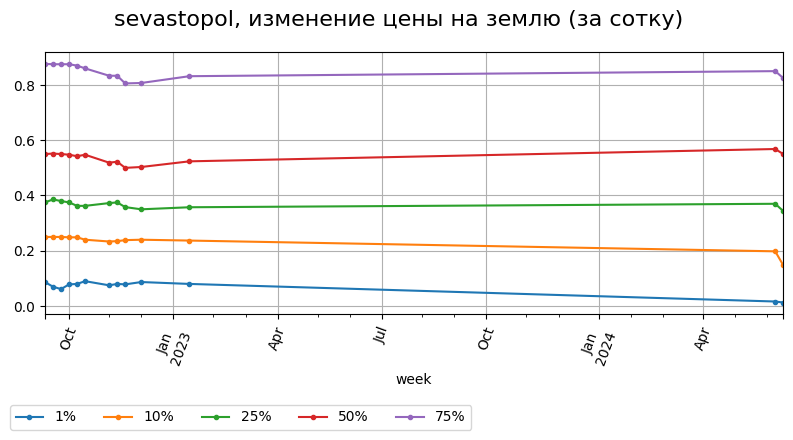

In [41]:
place = 'sevastopol'

fig, ax = plt.subplots(figsize=(8,4) )
stat.loc[(place,),cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

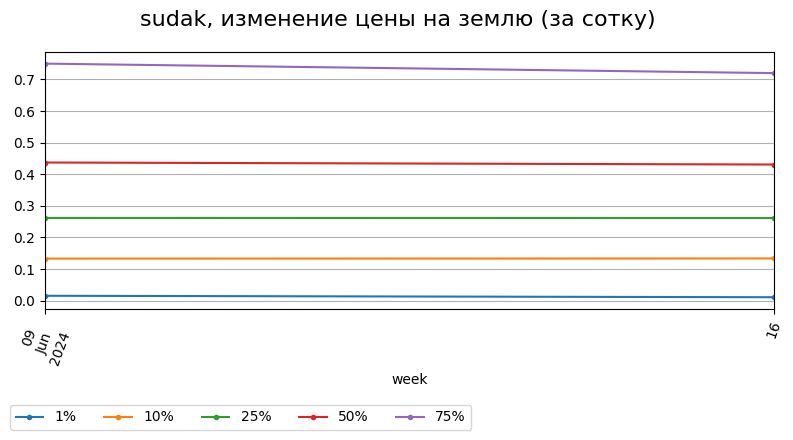

In [42]:
place = 'sudak'

fig, ax = plt.subplots(figsize=(8,4) )
stat.loc[(place,),cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

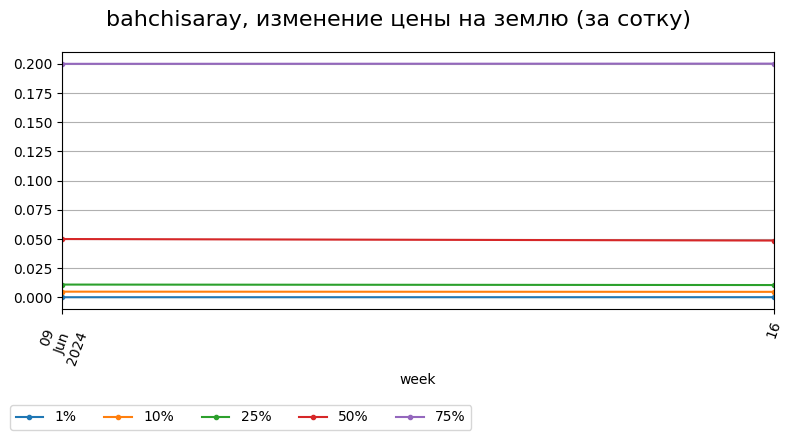

In [43]:
place = 'bahchisaray'

fig, ax = plt.subplots(figsize=(8,4) )
stat.loc[(place,),cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [44]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

36420

3564

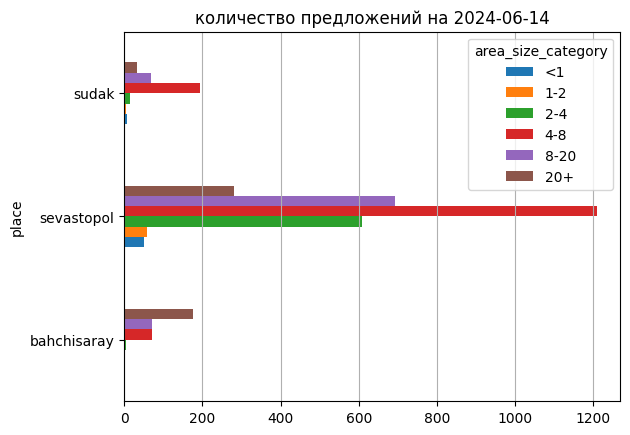

In [45]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [46]:
(
    gdf_last
    .groupby(['place'],observed=False)
    ['priceMU'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%  50%  75%  90%  95%  \
place                                                                         
bahchisaray  327.00  0.16 0.30 0.00 0.00 0.00 0.00 0.01 0.04 0.19 0.39 0.68   
sevastopol  2912.00  0.73 1.19 0.00 0.01 0.06 0.15 0.34 0.55 0.82 1.18 1.62   
sudak        325.00  0.60 0.65 0.00 0.01 0.07 0.13 0.25 0.42 0.73 1.07 1.69   

              max  
place              
bahchisaray  2.58  
sevastopol  16.00  
sudak        5.13

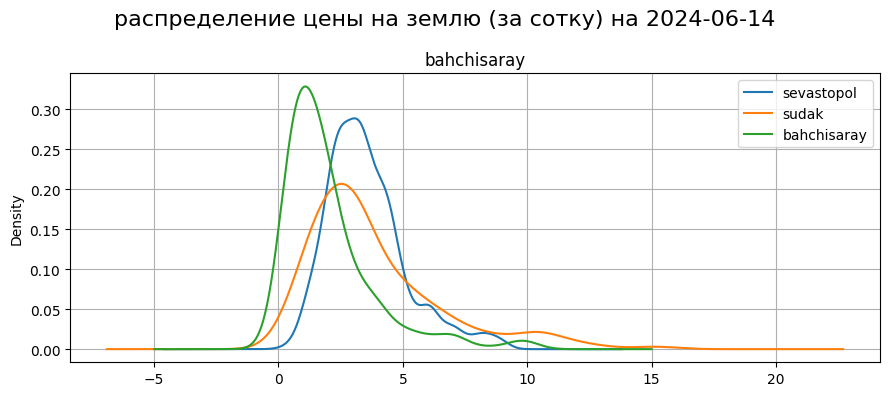

In [49]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

# fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
# for i,p in enumerate(places): 
#     (
#         gdf_last
#         .query(f'(place=="{p}")&(priceM<{q_95[p]})')
#         #.groupby(['area_size_category'],observed=True)
#         ['priceM']
#         .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
#     )

fig, ax = plt.subplots(figsize=(9,4))
for i,p in enumerate(places): 
    (
        gdf_last.query(f'(place=="{p}")&(priceM<{q_95[p]})')
        ['priceM'].plot.kde(legend=True,ax=ax,title=f'{p}', grid=True, label=p)   
    )

fig.suptitle(f'распределение цены на землю (за сотку) на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [50]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [51]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [52]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [53]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [54]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [55]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [56]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

## Судак

In [57]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [58]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [59]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

# районы Севастополя

In [60]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [61]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [62]:
frames.explore('area_name', legend=True)

In [63]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [64]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

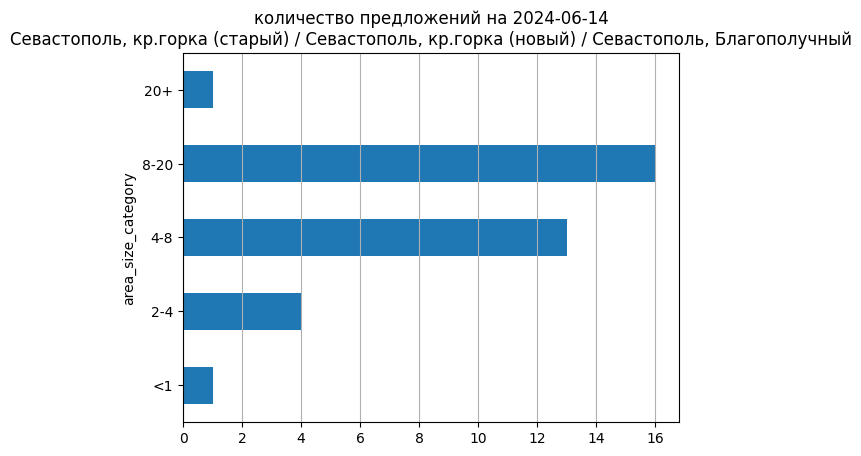

In [65]:
(
    gdf_last_local
    .groupby(['area_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

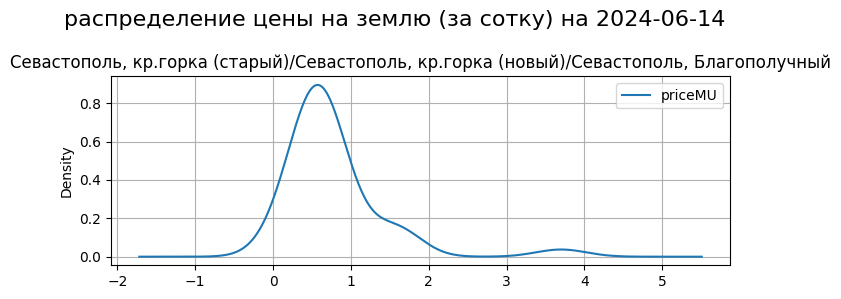

In [67]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    ['priceMU'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на землю (за сотку) на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [68]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [69]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = (
    gdf_local
    .groupby(['month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  75%  90%  max
month                                                                 
2022-09 389.00  0.62 0.27 0.17 0.17 0.34 0.37 0.48 0.56 0.68 0.85 1.78
2022-10  90.00  0.59 0.19 0.16 0.20 0.35 0.40 0.49 0.56 0.67 0.78 1.50
2022-11 219.00  0.58 0.22 0.15 0.20 0.38 0.40 0.47 0.53 0.62 0.85 2.00
2023-01  29.00  0.61 0.26 0.14 0.19 0.33 0.39 0.48 0.53 0.70 0.94 1.37
2024-06 221.00  0.82 0.59 0.09 0.09 0.21 0.41 0.49 0.59 0.90 1.60 3.70

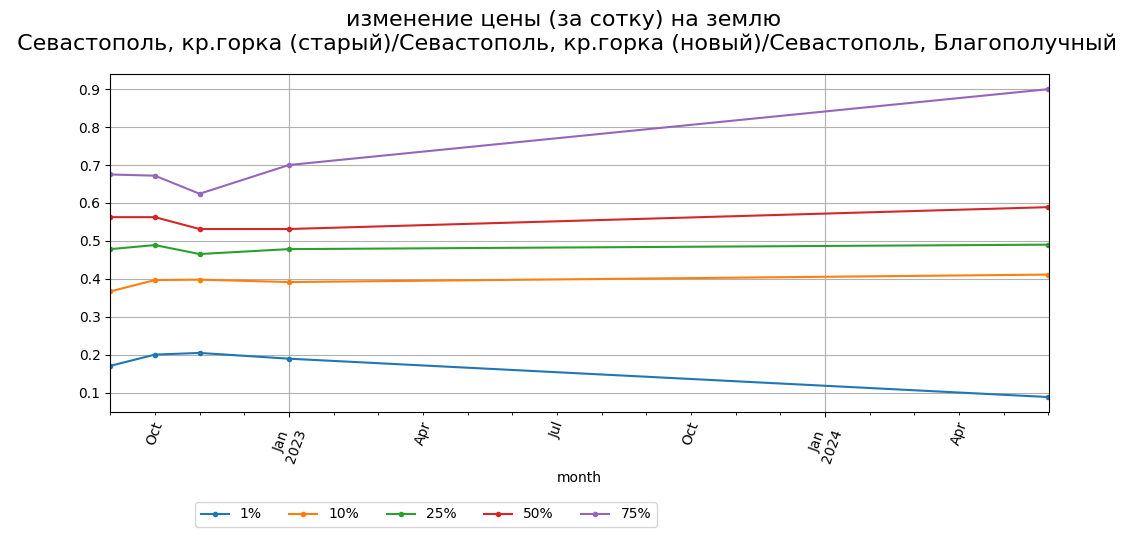

In [70]:
fig, ax = plt.subplots(figsize=(10,5) )
stat[cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )
fig.suptitle(f'изменение цены (за сотку) на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))
fig.tight_layout()